## 1. 이미지에서 텍스트 추출하기(easyOCR)

In [1]:
import easyocr
import numpy as np
import cv2
from typing import List, Dict
# from sklearn.cluster import KMeans

In [2]:
# 이미지 경로 지정
upload_image = 'test1.png'

In [3]:
reader = easyocr.Reader(['en'])
result = reader.readtext(upload_image)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [4]:
print(result)

[([[12, 14], [540, 14], [540, 87], [12, 87]], 'It was the best of', 0.9658043444948076), ([[7, 99], [686, 99], [686, 178], [7, 178]], 'times, it was the worst', 0.8693864604697936), ([[11, 181], [697, 181], [697, 267], [11, 267]], 'of times, it was the age', 0.7349637559231157), ([[11, 256], [649, 256], [649, 345], [11, 345]], 'of wisdom; it was the', 0.8425616344866556), ([[7, 344], [563, 344], [563, 433], [7, 433]], 'age of foolishness .', 0.8389083561447452)]


In [5]:
# image = cv2.imread(upload_image)

# # 색상 추출
# for (bbox, text, confidence) in result:
#     # 바운딩 박스 좌표
#     top_left = (int(bbox[0][0]), int(bbox[0][1]))
#     bottom_right = (int(bbox[2][0]), int(bbox[2][1]))

#     # 바운딩 박스 영역 추출
#     roi = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

#     # K-Means 클러스터링을 통한 색상 추출
#     roi_reshaped = roi.reshape((-1, 3))
#     k = 3  # 클러스터 수
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(roi_reshaped)

#     # 가장 많이 나타나는 색상 추출
#     dominant_color = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]

#     print(f"Detected text: {text}, Dominant Color (BGR): {dominant_color}")


In [6]:
OCR_RESULTS = []
print("✅ Result : ")
for res in result:
    OCR_RESULTS.append(res[0:2])
    print(res[0:2])


✅ Result : 
([[12, 14], [540, 14], [540, 87], [12, 87]], 'It was the best of')
([[7, 99], [686, 99], [686, 178], [7, 178]], 'times, it was the worst')
([[11, 181], [697, 181], [697, 267], [11, 267]], 'of times, it was the age')
([[11, 256], [649, 256], [649, 345], [11, 345]], 'of wisdom; it was the')
([[7, 344], [563, 344], [563, 433], [7, 433]], 'age of foolishness .')


## 2. 추출된 텍스트 번역
- 추출된 각 텍스트 영역에서 문맥상 이어지면 전체 문장을 고려하여 번역을 수행하고 다시 각 영역에 적절하게 번역된 텍스트 분배

In [7]:
from langchain.prompts import PromptTemplate
from langchain_core.prompts import load_prompt
from langchain_community.chat_models import ChatOpenAI

In [8]:
source_lang = "en"
target_lang = "ko"

### Translation Chain 생성

In [9]:
from dotenv import load_dotenv
from langchain_teddynote import logging
import os

# .env 파일 로드
load_dotenv(override=True)
print(os.getenv("LANGCHAIN_API_KEY"))
# LangSmith 로깅
logging.langsmith("Image-Translation")

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
LangSmith 추적을 시작합니다.
[프로젝트명]
Image-Translation


In [10]:
import ast

prompt = load_prompt("../../prompts/OCR_translate_paragraph.yaml", encoding="utf-8")

llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)
chain = prompt | llm

llm_result = chain.invoke({
    "OCR_RESULTS": OCR_RESULTS,
    "source_lang": source_lang,
    "target_lang": target_lang}
    )

def clean_content(content):
    # 첫 번째 '[' 위치 찾기
    start_idx = content.find('[')
    if start_idx == -1:  # '[' 가 없는 경우
        return content
    
    # '[' 이후의 내용만 추출
    cleaned_content = content[start_idx:]
    return cleaned_content

# 문자열 정제 후 Python 객체로 변환
cleaned_content = clean_content(llm_result.content)
print("정제된 내용:")
print(cleaned_content)

translated_results = ast.literal_eval(cleaned_content)

for index, result in enumerate(translated_results):
    print(f"\n결과 {index + 1}:")
    print(result)

C:\Users\COM-PPJU\AppData\Local\Temp\ipykernel_20408\1689995558.py:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)


정제된 내용:
[([[12, 14], [540, 14], [540, 87], [12, 87]], '최고의 시기였다'), ([[7, 99], [686, 99], [686, 178], [7, 178]], '최악의 시기였다'), ([[11, 181], [697, 181], [697, 267], [11, 267]], '지혜의 시대였다'), ([[11, 256], [649, 256], [649, 345], [11, 345]], '어리석음의 시대였다'), ([[7, 344], [563, 344], [563, 433], [7, 433]], '어리석음의 시대였다.')]

결과 1:
([[12, 14], [540, 14], [540, 87], [12, 87]], '최고의 시기였다')

결과 2:
([[7, 99], [686, 99], [686, 178], [7, 178]], '최악의 시기였다')

결과 3:
([[11, 181], [697, 181], [697, 267], [11, 267]], '지혜의 시대였다')

결과 4:
([[11, 256], [649, 256], [649, 345], [11, 345]], '어리석음의 시대였다')

결과 5:
([[7, 344], [563, 344], [563, 433], [7, 433]], '어리석음의 시대였다.')


### 후처리
- llm_chain에서 받은 결과가 완전하게 List 구조가 아닐 경우 에러 발생
- 따라서 발생가능성이 있는 상황에 대해 핸들러 추가
- llm_chain으로부터 답변 받은 내용은 문자열이기 때문에 이를 python 객체로 변환

## 3. 번역된 텍스트 융합 (fusing translated-text into the image)

In [11]:
# ! pip install Pillow opencv-python numpy

In [12]:
# # translated_text 전처리
# def adjust_bounding_boxes(translated_results):
#     # 바운딩 박스의 첫 번째 좌표의 x 값을 기준으로 정렬
#     translated_results.sort(key=lambda x: x[0][0][0])
    
#     # 조정된 결과를 저장할 리스트
#     adjusted_results = []
    
#     # 현재 그룹의 시작 인덱스
#     group_start_index = 0
    
#     for i in range(1, len(translated_results)):
#         # 현재 바운딩 박스의 첫 번째 좌표의 x 값
#         current_x = translated_results[i][0][0][0]
#         # 이전 바운딩 박스의 첫 번째 좌표의 x 값
#         previous_x = translated_results[i-1][0][0][0]
        
#         # x 좌표 차이가 5px 이내인지 확인
#         if current_x - previous_x > 5:
#             # 그룹 내의 모든 바운딩 박스를 최솟값으로 조정
#             min_x = min(translated_results[j][0][0][0] for j in range(group_start_index, i))
#             for j in range(group_start_index, i):
#                 bbox, text = translated_results[j]
#                 # x 좌표 조정 (첫 번째와 네 번째 좌표)
#                 adjusted_bbox = [
#                     [min_x, bbox[0][1]],  # 첫 번째 좌표
#                     bbox[1],              # 두 번째 좌표
#                     bbox[2],              # 세 번째 좌표
#                     [min_x, bbox[3][1]]   # 네 번째 좌표
#                 ]
#                 adjusted_results.append((adjusted_bbox, text))
            
#             # 새로운 그룹 시작
#             group_start_index = i
    
#     # 마지막 그룹 처리
#     min_x = min(translated_results[j][0][0][0] for j in range(group_start_index, len(translated_results)))
#     for j in range(group_start_index, len(translated_results)):
#         bbox, text = translated_results[j]
#         adjusted_bbox = [
#             [min_x, bbox[0][1]],  # 첫 번째 좌표
#             bbox[1],              # 두 번째 좌표
#             bbox[2],              # 세 번째 좌표
#             [min_x, bbox[3][1]]   # 네 번째 좌표
#         ]
#         adjusted_results.append((adjusted_bbox, text))
    
#     return adjusted_results


In [13]:
# adjusted_results = adjust_bounding_boxes(translated_results)

# for result in adjusted_results:
#     print(result)

In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from collections import Counter
from PIL import Image, ImageDraw, ImageFont

fontpath = r"C:\Users\COM-PPJU\AppData\Local\Microsoft\Windows\Fonts\NanumGothic.ttf"

def create_mask(image, bbox):
    """바운딩 박스 영역의 마스크 생성"""
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    pts = np.array(bbox, np.int32)
    cv2.fillPoly(mask, [pts], 255)
    return mask

# def extract_text_style(image, bbox, background_color):
#     """원본 텍스트의 스타일(색상, 폰트 크기 등)을 추출하는 함수"""
#     # 바운딩 박스 영역 추출
#     x1, y1 = bbox[0]
#     x2, y2 = bbox[2]
#     text_region = image[y1:y2, x1:x2]
    
#     # 색상 추출
#     pixels = text_region.reshape(-1, 3)
    
#     # 배경 색상과 유사한 색상 제외
#     tolerance = 30  # 허용 오차
#     distances = np.linalg.norm(pixels - background_color, axis=1)
#     mask = distances > tolerance
#     filtered_pixels = pixels[mask]
#     print("filtered_pixels : ", filtered_pixels)

#     if len(filtered_pixels) == 0:
#         return (0, 0, 0), 0  # 색상 추출 실패 시 기본값 반환

#     # 가장 많이 나타나는 색상 선택
#     most_common_color = Counter(map(tuple, filtered_pixels)).most_common(1)[0][0]
    
#     # 폰트 크기 추정 (바운딩 박스 높이 사용)
#     font_size = y2 - y1 - 5
    
#     return most_common_color, font_size

def extract_text_style(image, bbox, background_color):
    """원본 텍스트의 스타일(색상, 폰트 크기 등)을 추출하는 함수"""
    # 바운딩 박스 영역 추출
    x1, y1 = bbox[0]
    x2, y2 = bbox[2]
    text_region = image[y1:y2, x1:x2]

    # text_region 시각화
    plt.imshow(cv2.cvtColor(text_region, cv2.COLOR_BGR2RGB))
    plt.title("Text Region")
    plt.axis('off')
    plt.show()
    
    # RGB에서 HSV로 변환
    text_region_hsv = cv2.cvtColor(text_region, cv2.COLOR_BGR2HSV)
    background_color_hsv = cv2.cvtColor(np.uint8([[background_color]]), cv2.COLOR_BGR2HSV)[0][0]
    
    # 색상 추출
    pixels = text_region_hsv.reshape(-1, 3)
    
    # 배경 색상과 유사한 색상 제외
    tolerance = 30  # 허용 오차
    hue_diff = np.abs(pixels[:, 0] - background_color_hsv[0])
    saturation_diff = np.abs(pixels[:, 1] - background_color_hsv[1])
    value_diff = np.abs(pixels[:, 2] - background_color_hsv[2])
    
    mask = (hue_diff > tolerance) | (saturation_diff > tolerance) | (value_diff > tolerance)
    filtered_pixels = pixels[mask]
    print("filtered_pixels : ", filtered_pixels)

    if len(filtered_pixels) == 0:
        return (0, 0, 0), 0  # 색상 추출 실패 시 기본값 반환

    # 가장 많이 나타나는 색상 선택
    most_common_color_hsv = Counter(map(tuple, filtered_pixels)).most_common(1)[0][0]
    most_common_color = cv2.cvtColor(np.uint8([[most_common_color_hsv]]), cv2.COLOR_HSV2BGR)[0][0]
    
    # 폰트 크기 추정 (바운딩 박스 높이 사용)
    font_size = y2 - y1 - 5
    
    return (0,0,0), font_size

In [15]:
def process_image_with_steps(image_path, translated_results, original_results):
    # 1. 원본 이미지 로드
    original_image = cv2.imread(image_path)
    image = original_image.copy()
    
    # 2. 마스크 생성
    combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for bbox, _ in original_results:
        mask = create_mask(image, bbox)
        combined_mask = cv2.bitwise_or(combined_mask, mask)
    
    # 3. 텍스트 영역 제거된 이미지 생성
    masked_image = image.copy()
    masked_image[combined_mask == 255] = [255, 255, 255]  # 흰색으로 채우기
    
    # 4. 인페인팅으로 텍스트 영역 채우기
    inpainted_image = cv2.inpaint(image, combined_mask, 3, cv2.INPAINT_TELEA)

    # 5. 배경 색상 추출
    inpainted_pixels = inpainted_image.reshape(-1, 3)
    background_color = Counter(map(tuple, inpainted_pixels)).most_common(1)[0][0]
    
    # 6. 번역된 텍스트 추가
    translated_image = Image.fromarray(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(translated_image)
    
    # 1단계: x 좌표가 5px 이내로 차이나는 바운딩 박스 그룹화 및 통일
    translated_results.sort(key=lambda x: x[0][0][0])  # x 좌표 기준 정렬
    x_grouped_results = []
    current_group = []
    min_x = None
    
    for i, (bbox, translated_text) in enumerate(translated_results):
        current_x = bbox[0][0]
        
        if i == 0 or (current_x - min_x <= 5):
            current_group.append((bbox, translated_text))
            min_x = min(min_x, current_x) if min_x is not None else current_x
        else:
            x_grouped_results.append((min_x, current_group))
            current_group = [(bbox, translated_text)]
            min_x = current_x
    
    if current_group:
        x_grouped_results.append((min_x, current_group))
    
    # 2단계: 원본 텍스트 스타일 추출 및 적용
    for min_x, group in x_grouped_results:
        for bbox, translated_text in group:
            # 원본 텍스트 스타일 추출
            color, font_size = extract_text_style(original_image, bbox, background_color)

            print("bbox : ", bbox)
            print("color : ", color)
            print("font_size : ", font_size)
            print()
            
            # 폰트 설정 (적절한 경로로 변경)
            font_path = r"C:\Users\COM-PPJU\AppData\Local\Microsoft\Windows\Fonts\NanumGothic.ttf"
            font = ImageFont.truetype(font_path, font_size)
            
            # x 좌표를 min_x로 통일
            adjusted_bbox = [
                [min_x, bbox[0][1]],  # 첫 번째 좌표
                [min_x, bbox[1][1]],  # 두 번째 좌표
                bbox[2],              # 세 번째 좌표
                bbox[3]               # 네 번째 좌표
            ]
            
            # 텍스트 왼쪽 정렬
            x = adjusted_bbox[0][0]
            y = adjusted_bbox[0][1]
            draw.text((x, y), translated_text, font=font, fill=tuple(color))
    
    # 모든 이미지를 RGB로 변환
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    masked_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
    inpainted_rgb = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)
    
    # matplotlib 폰트 설정
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 폰트 추가
    fm.fontManager.addfont(fontpath)
    plt.rcParams['font.family'] = 'NanumGothic'

    # 결과 시각화
    plt.figure(figsize=(10,20))
    
    plt.subplot(411)
    plt.title('1. 원본 이미지', fontsize=12)
    plt.imshow(original_rgb)
    plt.axis('off')
    
    plt.subplot(412)
    plt.title('2. 원본 텍스트 영역 마스크 생성', fontsize=12)
    plt.imshow(combined_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(413)
    plt.title('3. 텍스트 영역 채우기(인페인팅)', fontsize=12)
    plt.imshow(inpainted_rgb)
    plt.axis('off')
    
    plt.subplot(414)
    plt.title('4. 번역 텍스트 추가', fontsize=12)
    plt.imshow(translated_image)
    plt.axis('off')
    
    plt.tight_layout(pad=3.0) 
    plt.show()
    
    return translated_image

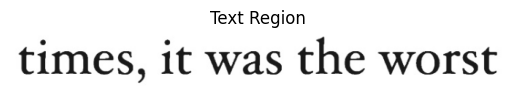

filtered_pixels :  [[  0   0 254]
 [  0   0 254]
 [  0   0 254]
 ...
 [  0   0 253]
 [  0   0 254]
 [  0   0 254]]
bbox :  [[7, 99], [686, 99], [686, 178], [7, 178]]
color :  (0, 0, 0)
font_size :  74



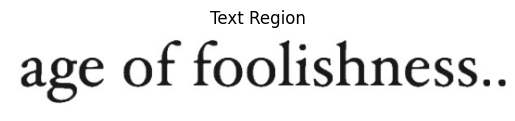

filtered_pixels :  [[  0   0 254]
 [  0   0 254]
 [  0   0 254]
 ...
 [  0   0 253]
 [  0   0 254]
 [  0   0 254]]
bbox :  [[7, 344], [563, 344], [563, 433], [7, 433]]
color :  (0, 0, 0)
font_size :  84



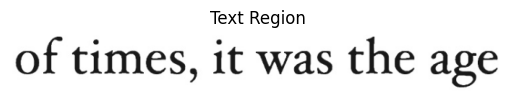

filtered_pixels :  [[  0   0 254]
 [  0   0 254]
 [  0   0 253]
 ...
 [  0   0 254]
 [  0   0 254]
 [  0   0 253]]
bbox :  [[11, 181], [697, 181], [697, 267], [11, 267]]
color :  (0, 0, 0)
font_size :  81



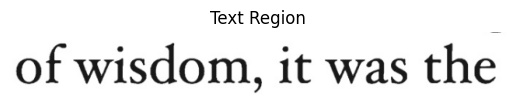

filtered_pixels :  [[  0   0 253]
 [  0   0 252]
 [  0   0 252]
 ...
 [  0   0 254]
 [  0   0 254]
 [  0   0 254]]
bbox :  [[11, 256], [649, 256], [649, 345], [11, 345]]
color :  (0, 0, 0)
font_size :  84



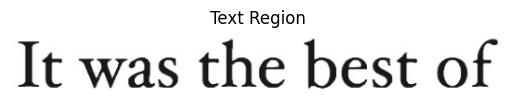

filtered_pixels :  [[  0   0 254]
 [  0   0 254]
 [  0   0 254]
 ...
 [  0   0 254]
 [  0   0 254]
 [  0   0 254]]
bbox :  [[12, 14], [540, 14], [540, 87], [12, 87]]
color :  (0, 0, 0)
font_size :  68



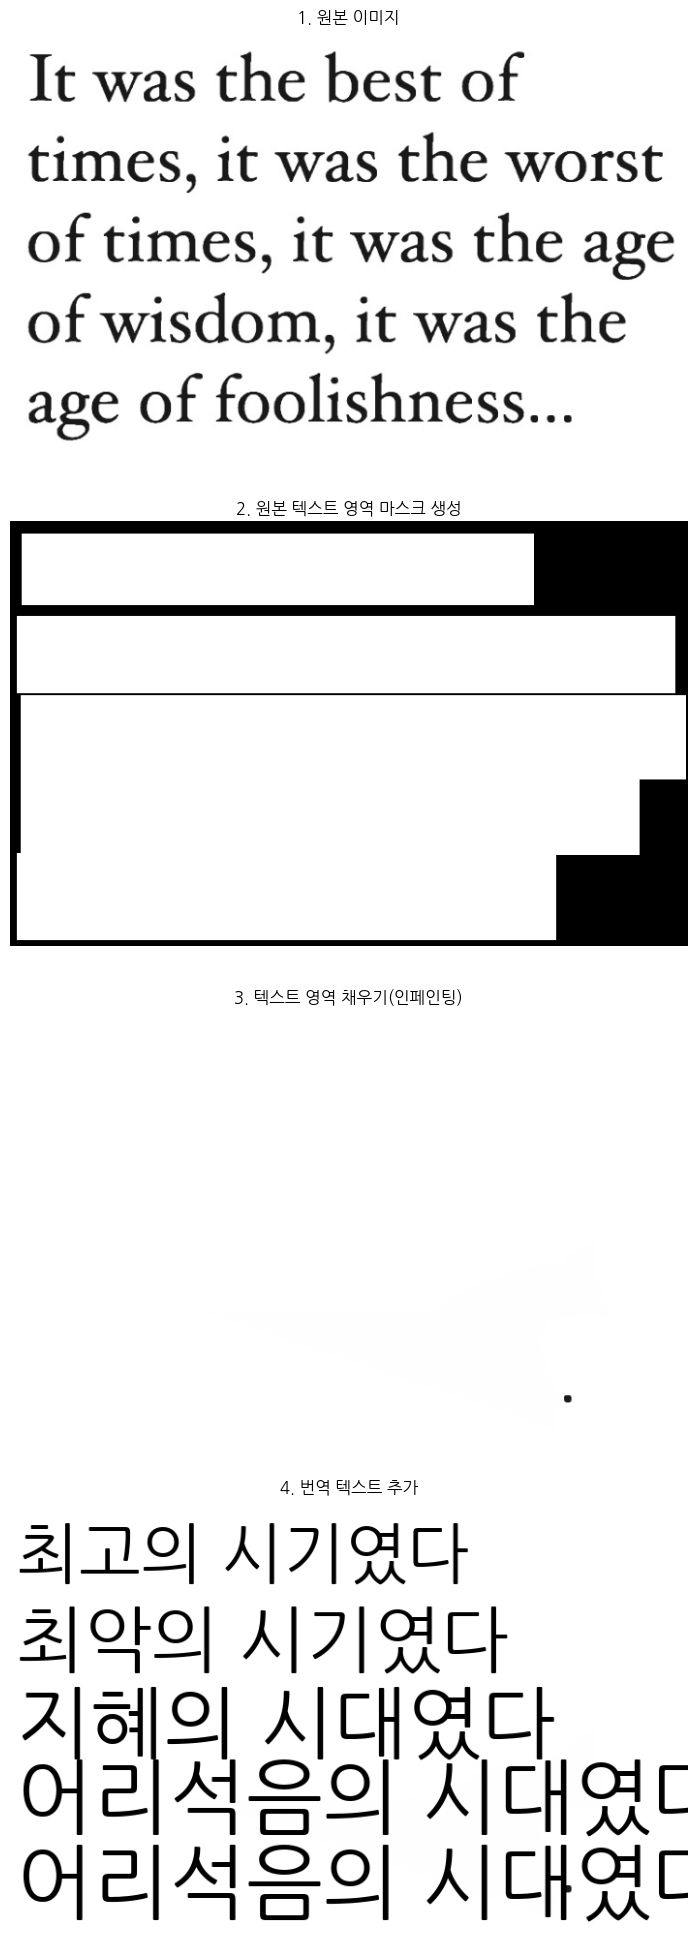

In [16]:
# 사용 예시
# image_path = "./test1.png"
result_image = process_image_with_steps(upload_image, translated_results, OCR_RESULTS)

# 결과 저장
result_image.save("translated_image3_2.png")

In [46]:
def enhance_image_quality(image_input, visualize=True):
    """이미지 화질 개선을 위한 전처리 함수
    
    Args:
        image_input: str 또는 numpy.ndarray - 이미지 경로 또는 이미지 배열
        visualize: bool - 시각화 여부
    """
    try:
        # 이미지 입력이 경로인 경우 처리
        if isinstance(image_input, str):
            image = cv2.imread(image_input)
            if image is None:
                raise ValueError(f"이미지를 불러올 수 없습니다: {image_input}")
        else:
            image = image_input
            
        if visualize:
            plt.figure(figsize=(20, 10))
            
            # 원본 이미지 표시
            plt.subplot(2, 3, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('원본 이미지')
            plt.axis('off')
        
        # 1. 이미지 크기 확대 (2배)
        height, width = image.shape[:2]
        image = cv2.resize(image, (width*2, height*2), interpolation=cv2.INTER_CUBIC)
        
        if visualize:
            plt.subplot(2, 3, 2)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('크기 확대 (2배)')
            plt.axis('off')
        
        # 2. 노이즈 제거
        denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
        
        if visualize:
            plt.subplot(2, 3, 3)
            plt.imshow(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))
            plt.title('노이즈 제거')
            plt.axis('off')
        
        # 3. 선명도 개선
        kernel = np.array([[-1,-1,-1], 
                         [-1, 9,-1],
                         [-1,-1,-1]])
        sharpened = cv2.filter2D(denoised, -1, kernel)
        
        if visualize:
            plt.subplot(2, 3, 4)
            plt.imshow(cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB))
            plt.title('선명도 개선')
            plt.axis('off')
        
        # 4. 대비 향상
        lab = cv2.cvtColor(sharpened, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        enhanced_lab = cv2.merge((cl,a,b))
        final = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
        
        if visualize:
            plt.subplot(2, 3, 5)
            plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
            plt.title('대비 향상 (최종)')
            plt.axis('off')
            
            # 히스토그램 추가
            plt.subplot(2, 3, 6)
            colors = ('b', 'g', 'r')
            for i, color in enumerate(colors):
                hist = cv2.calcHist([final], [i], None, [256], [0, 256])
                plt.plot(hist, color=color)
            plt.title('RGB 히스토그램')
            plt.xlim([0, 256])
            
            plt.tight_layout()
            plt.show()
        
        return final
    
    except Exception as e:
        print(f"이미지 화질 개선 중 오류 발생: {str(e)}")
        if isinstance(image_input, str):
            return cv2.imread(image_input)  # 원본 이미지 반환
        return image_input  # 원본 이미지 반환

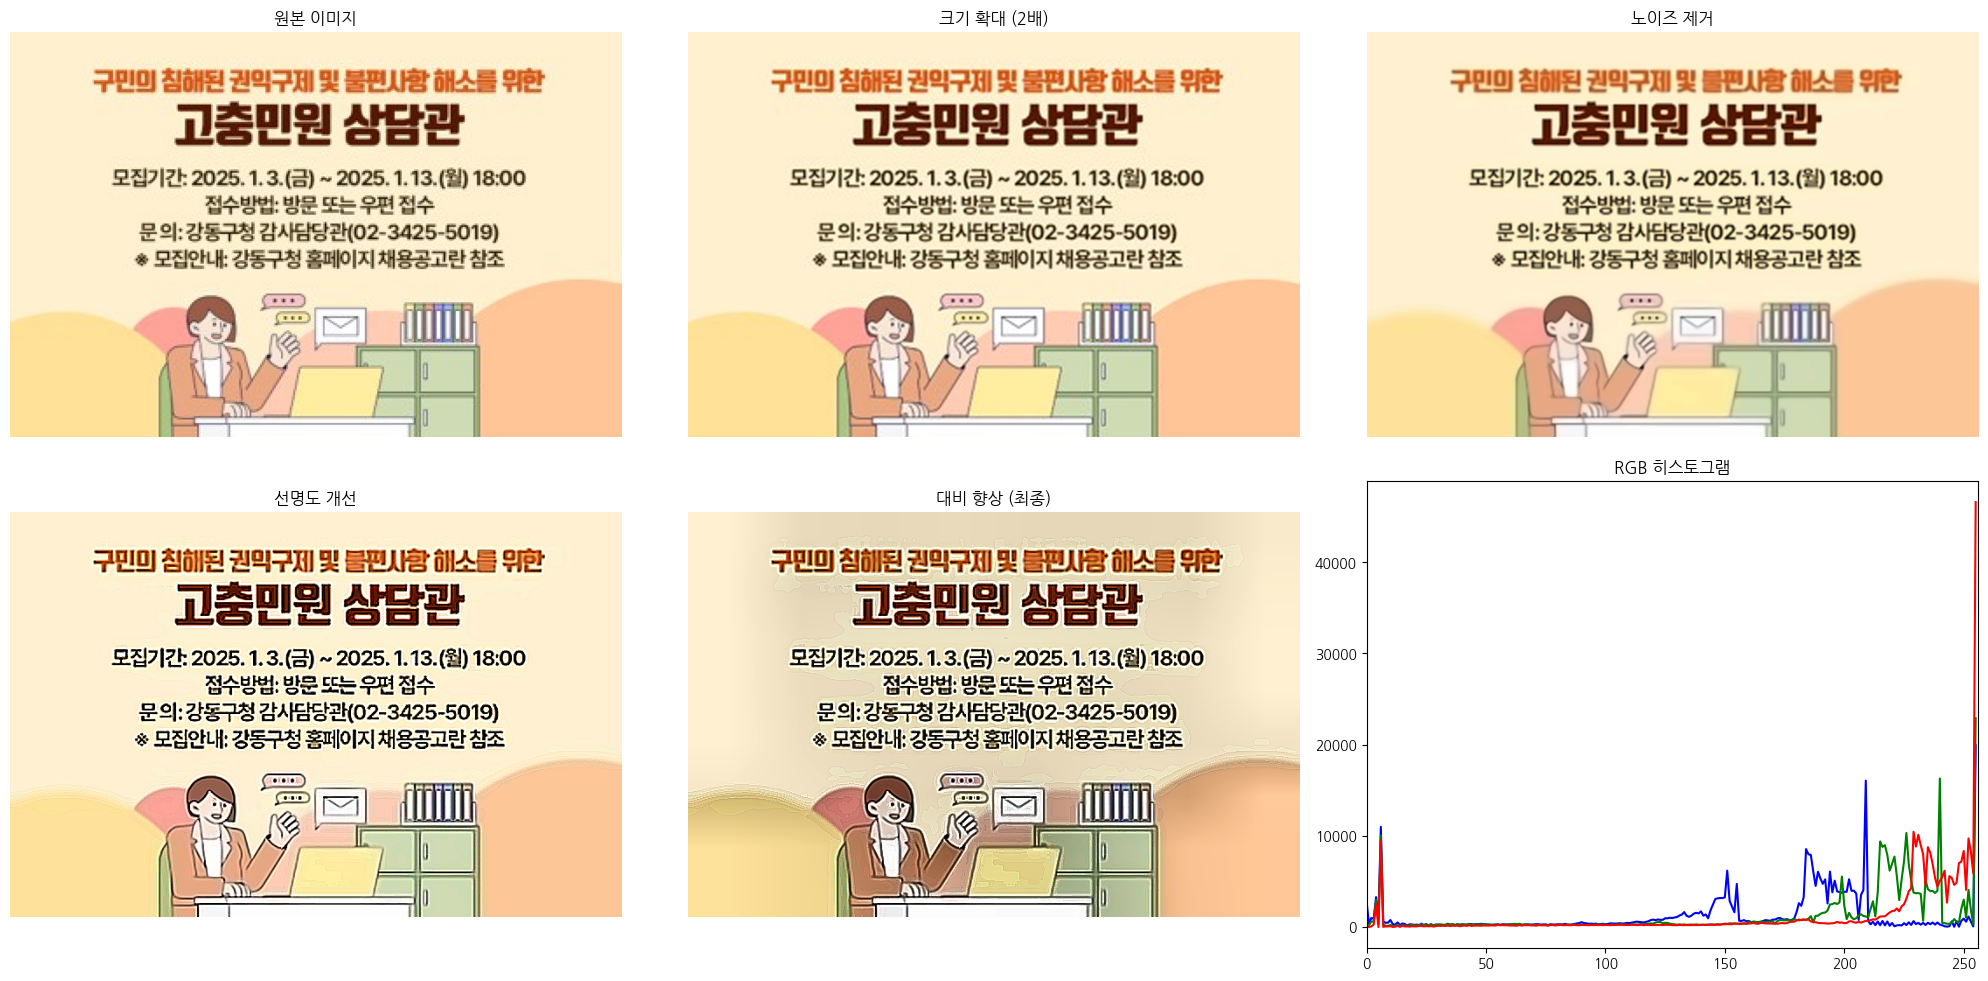

In [47]:
upload_image = './test3.jpg'
upload_image = enhance_image_quality(upload_image)


In [43]:
reader = easyocr.Reader(['en','ko'])
result = reader.readtext(upload_image)
print(result)
OCR_RESULTS = []
print("✅ Result : ")
for res in result:
    OCR_RESULTS.append(res[0:2])
    print(res[0:2])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[89, 35], [617, 35], [617, 77], [89, 77]], '구민미치해문 권의구제 및 드의금해소등 위한', 0.015420919009232478), ([[180, 70], [528, 70], [528, 142], [180, 142]], '고충민원 상담관', 0.5834877023497396), ([[113, 151], [597, 151], [597, 187], [113, 187]], '모집기간:2025.1.3.(금) ~ 2025.1.13 (원) 18,00', 0.4914345223920828), ([[220, 184], [490, 184], [490, 216], [220, 216]], '점수방범; 방문 또는우편 점수', 0.496236869661709), ([[143, 213], [565, 213], [565, 249], [143, 249]], '문의:강동구청감사담당관(02-3425-5019)', 0.8531010518276353), ([[162, 246], [570, 246], [570, 278], [162, 278]], '모집안내; 강동구청 콤폐이지채용공고환참조', 0.3639100375812558)]
✅ Result : 
([[89, 35], [617, 35], [617, 77], [89, 77]], '구민미치해문 권의구제 및 드의금해소등 위한')
([[180, 70], [528, 70], [528, 142], [180, 142]], '고충민원 상담관')
([[113, 151], [597, 151], [597, 187], [113, 187]], '모집기간:2025.1.3.(금) ~ 2025.1.13 (원) 18,00')
([[220, 184], [490, 184], [490, 216], [220, 216]], '점수방범; 방문 또는우편 점수')
([[143, 213], [565, 213], [565, 249], [143, 249]], '문의:강동구청감사담당관(02-3425-5019)')
([[162, 246], [570, 246],

In [28]:
source_lang = "ko"
target_lang = "en"

In [29]:
prompt = load_prompt("../../prompts/OCR_translate_paragraph.yaml", encoding="utf-8")

llm = ChatOpenAI(model_name="gpt-4.1", temperature=0.0)
chain = prompt | llm

llm_result = chain.invoke({
    "OCR_RESULTS": OCR_RESULTS,
    "source_lang": source_lang,
    "target_lang": target_lang}
    )

translated_results = ast.literal_eval(llm_result.content)

for index, result in enumerate(translated_results):
    print(result)

([[44, 16], [178, 16], [178, 40], [44, 40]], 'Remedies for Infringed Rights of Residents')
([[188, 16], [308, 16], [308, 40], [188, 40]], 'For Resolving Inconveniences and Complaints')
([[89, 35], [265, 35], [265, 73], [89, 73]], 'Senior Civil Complaint Counselor')
([[57, 77], [177, 77], [177, 93], [57, 93]], 'Recruitment Period: 2025.1.3 (Fri)')
([[185, 77], [299, 77], [299, 93], [185, 93]], 'to 2025.1.13 (Mon) 18:00')
([[111, 91], [245, 91], [245, 109], [111, 109]], 'How to Apply: In person or by mail')
([[73, 107], [283, 107], [283, 123], [73, 123]], 'Inquiries: Gangdong-gu Office Audit Officer (02-3425-5019)')
([[81, 123], [285, 123], [285, 139], [81, 139]], 'Recruitment Info: Refer to the Gangdong-gu Office website announcement section')


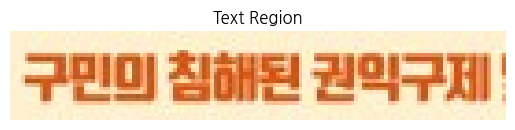

filtered_pixels :  [[ 19  52 255]
 [ 22  43 253]
 [ 27  44 248]
 ...
 [ 19  51 255]
 [ 27  43 247]
 [ 29  41 247]]
bbox :  [[44, 16], [178, 16], [178, 40], [44, 40]]
color :  (0, 0, 0)
font_size :  19



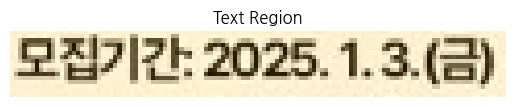

filtered_pixels :  [[ 21  48 253]
 [ 21  49 252]
 [ 22  45 255]
 ...
 [ 23  41 255]
 [ 21  46 250]
 [ 22  47 255]]
bbox :  [[57, 77], [177, 77], [177, 93], [57, 93]]
color :  (0, 0, 0)
font_size :  11



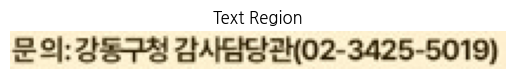

filtered_pixels :  [[ 22  46 255]
 [ 22  45 255]
 [ 22  46 255]
 ...
 [ 20  46 253]
 [ 21  48 253]
 [ 21  48 254]]
bbox :  [[73, 107], [283, 107], [283, 123], [73, 123]]
color :  (0, 0, 0)
font_size :  11



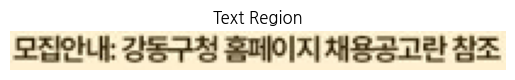

filtered_pixels :  [[ 22  48 252]
 [ 22  46 255]
 [ 22  47 255]
 ...
 [ 21  47 255]
 [ 21  48 254]
 [ 21  48 254]]
bbox :  [[81, 123], [285, 123], [285, 139], [81, 139]]
color :  (0, 0, 0)
font_size :  11



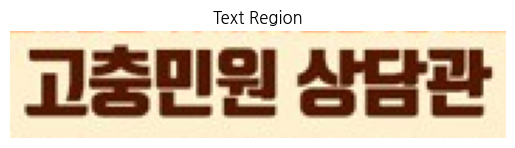

filtered_pixels :  [[ 14 106 254]
 [ 13 108 255]
 [ 13 110 255]
 ...
 [ 23  44 255]
 [ 21  49 252]
 [ 21  47 255]]
bbox :  [[89, 35], [265, 35], [265, 73], [89, 73]]
color :  (0, 0, 0)
font_size :  33



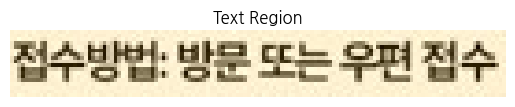

filtered_pixels :  [[ 22  47 253]
 [ 22  43 255]
 [ 21  45 255]
 ...
 [ 21  47 255]
 [ 21  49 252]
 [ 21  49 250]]
bbox :  [[111, 91], [245, 91], [245, 109], [111, 109]]
color :  (0, 0, 0)
font_size :  13



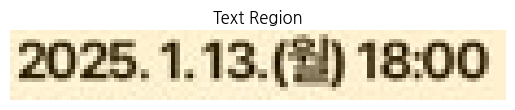

filtered_pixels :  [[ 21  48 254]
 [ 22  47 253]
 [ 22  48 250]
 ...
 [ 21  48 254]
 [ 21  48 254]
 [ 21  49 252]]
bbox :  [[185, 77], [299, 77], [299, 93], [185, 93]]
color :  (0, 0, 0)
font_size :  11



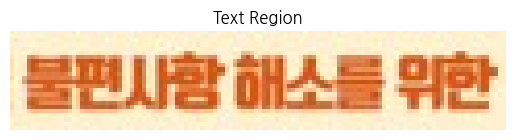

filtered_pixels :  [[ 27  49 245]
 [ 28  47 249]
 [ 26  41 248]
 ...
 [ 20  49 255]
 [ 21  48 254]
 [ 21  47 255]]
bbox :  [[188, 16], [308, 16], [308, 40], [188, 40]]
color :  (0, 0, 0)
font_size :  19



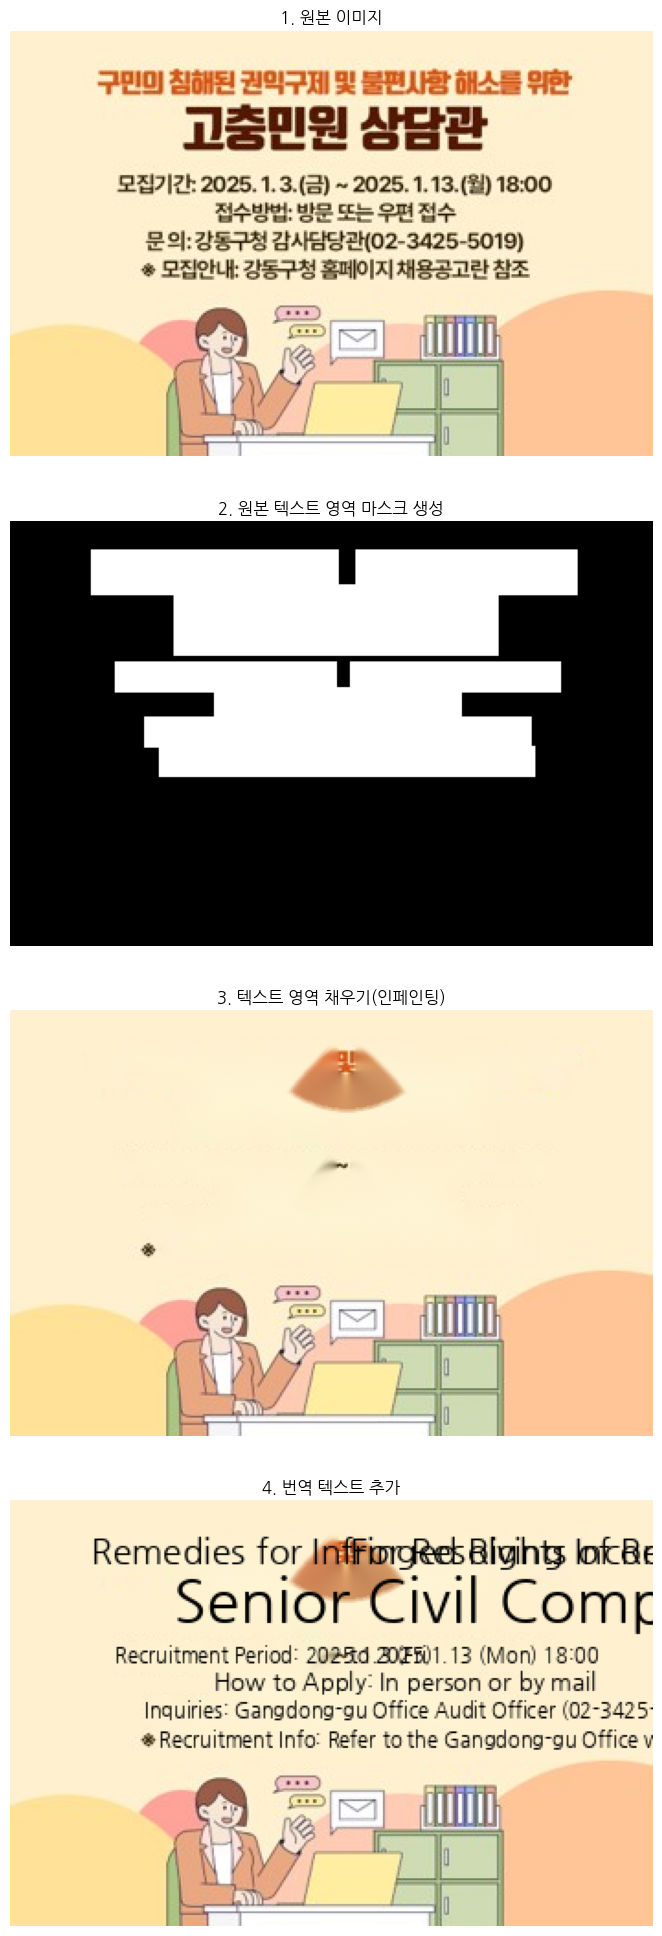

In [30]:
result_image = process_image_with_steps(upload_image, translated_results, OCR_RESULTS)

result_image.save("translated_image3.png")